# Assessment of the crowdsourcing results

# 0. Import dependencies and inputs

In [369]:
%run ../notebook_preamble_Transitions.ipy
from scipy.stats import pearsonr, spearmanr
import mapping_career_causeways.plotting_utils as plotting_utils

# Crowdsourcing dataset
inputs_folder = f'{data_folder}processed/validation/'

batch_1 = pd.read_csv(inputs_folder + 'Transitions_to_validate_BATCH_1.csv')
batch_2 = pd.read_csv(inputs_folder + 'Transitions_to_validate_BATCH_2.csv')
batch = pd.concat([batch_1, batch_2], axis=0)

# Crowd feasibility ratings
batch_results = pd.read_csv(inputs_folder + 'crowd_feasibility_ratings.csv', low_memory=False)

# Occupation similarity matrices
sims = load_data.Similarities()


In [38]:
# Location for exporting the processed data
figure_folder = useful_paths.codebase_dir + 'reports/crowd_feasibility_ratings/figures/'

# Set up font sizes for plots
SMALL_SIZE = 13
MEDIUM_SIZE=14
plt.rc('font', size=SMALL_SIZE, family='Arial')
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

In [39]:
batch_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70359 entries, 0 to 70358
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   classification_id                 70359 non-null  int64 
 1   subject_ids                       70359 non-null  int64 
 2   origin_id                         70359 non-null  int64 
 3   origin_label                      70359 non-null  object
 4   origin_description                70359 non-null  object
 5   destination_id                    70359 non-null  int64 
 6   destination_label                 70359 non-null  object
 7   destination_description           70359 non-null  object
 8   perfectly_matched_skills          59402 non-null  object
 9   partially_matched_skills          53095 non-null  object
 10  unmatched_skills                  69501 non-null  object
 11  familiarity_with_origin_1-5       70359 non-null  int64 
 12  familiarity_with_d

In [61]:
# Check that there are no duplicates
assert(len(batch_results.drop_duplicates(['classification_id'])) == len(batch_results))
assert(len(batch_results.drop_duplicates(['subject_ids', 'coder_id'])) == len(batch_results))

# 1. Check the validations results dataset

## 1.1 Basic stats

In [40]:
batch_results.head()

,classification_id,subject_ids,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,...,familiarity_with_destination_1-5,feasibility_1-5,Reasons,coder_id,questionable_respondant_flag,gender,background,highest_qualification,time_stamp,age_group
0,289643147,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,2,3,**Qualifications** - different qualification r...,566802cf6d9c32c4b9d6,False,Male,"['Education','Healthcare']",Master'degree,NaN,20-29
1,289715915,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,3,3,"**Skills** - poor skills overlap, missing esse...",dfaa44417fdef5173766,False,Female,"['Healthcare', 'Sales and services']",Bachelor's degree,NaN,50-59
2,289776880,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,1,2,"**Skills** - poor skills overlap, missing esse...",b929c3beb0e7ffb1ea4a,False,Male,"['Education','Engineering and research']",Doctorate,NaN,30-39
3,289806895,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,4,1,**Qualifications** - different qualification r...,20df3373ab16becb8f2e,False,Male,['Sales and services'],GCSE,NaN,30-39
4,290219173,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,2,2,**Qualifications** - different qualification r...,ef345455b53500fbb303,False,Female,"['Business and administration', 'Public sector...",Bachelor's degree,NaN,30-39


In [41]:
# Total number of ratings
len(batch_results)

70359

In [42]:
# Total number of assessed transitions 
len(batch_results.subject_ids.unique())

9113

In [43]:
# Total number of unique occupations included in the study
len(set(batch_results.origin_id.unique()).union(set(batch_results.destination_id.unique())))

1571

In [44]:
# Total number of unique contributors
len(batch_results.coder_id.unique())

387

### Feasibility

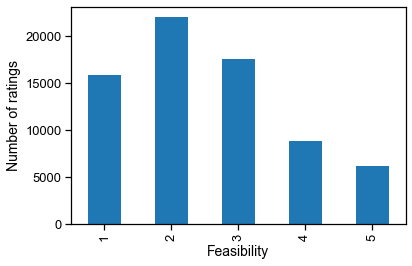

In [53]:
# Distribution of feasibility ratings
fig, ax = plt.subplots()

batch_results.groupby('feasibility_1-5').agg({'classification_id': 'count'}).plot.bar(ax=ax, legend=None)
ax.set_xlabel('Feasibility')
ax.set_ylabel('Number of ratings')
plotting_utils.export_figure('ratings_Feasibility_distribution', figure_folder=figure_folder, png=True, svg=True)

In [77]:
batch_results['feasibility_1-5'].mean().round(2)

2.54

The distribution of feasibility ratings appears to follow a skewed normal distribution.

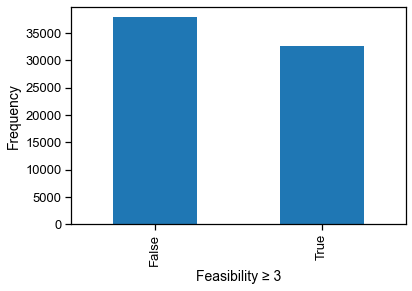

In [78]:
fig, ax = plt.subplots()

(batch_results['feasibility_1-5'] > 2).value_counts().plot.bar()
ax.set_xlabel('Feasibility ≥ 3')
ax.set_ylabel('Frequency');

In [80]:
# Fraction of 'feasible' ratings
np.sum(batch_results['feasibility_1-5'] > 2) / len(batch_results)

0.46211572080330876

### Familiarity

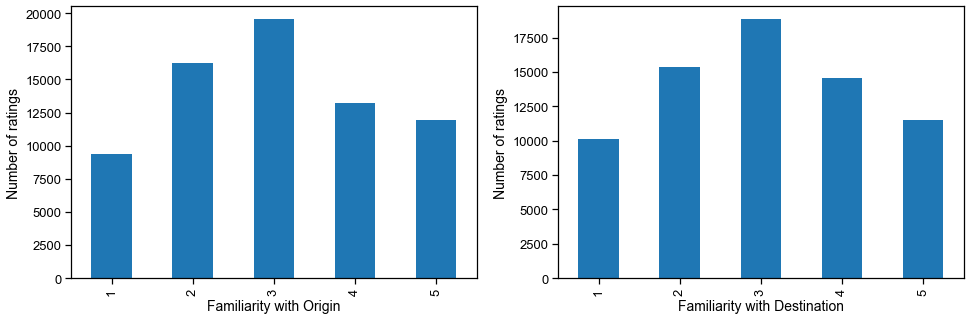

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

batch_results.groupby('familiarity_with_origin_1-5').agg({'classification_id': 'count'}).plot.bar(ax=axs[0], legend=None)
axs[0].set_xlabel('Familiarity with Origin')
axs[0].set_ylabel('Number of ratings')
batch_results.groupby('familiarity_with_destination_1-5').agg({'classification_id': 'count'}).plot.bar(ax=axs[1], legend=None)
axs[1].set_xlabel('Familiarity with Destination')
axs[1].set_ylabel('Number of ratings');

plotting_utils.export_figure('ratings_Familiarity', figure_folder=figure_folder, png=True, svg=True)

The distribution of familiarity for both the origin and destination jobs.

In [63]:
batch_results['familiarity_with_origin_1-5'].mean().round(2)

3.03

In [64]:
batch_results['familiarity_with_destination_1-5'].mean().round(2)

3.03

### Most and least familiar occupations

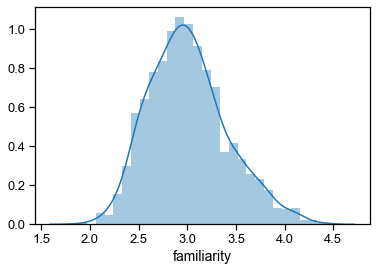

In [191]:
occupation_familiarity_all = pd.DataFrame(data={
    'id': batch_results['origin_id'].to_list() + batch_results['destination_id'].to_list(),
    'label': batch_results['origin_label'].to_list() + batch_results['destination_label'].to_list(),    
    'familiarity': batch_results['familiarity_with_origin_1-5'].to_list() + batch_results['familiarity_with_destination_1-5'].to_list(),
})

occupation_familiarity = occupation_familiarity_all.groupby('id').agg({'familiarity': 'mean'}).reset_index()
occupation_familiarity = occupation_familiarity.merge(occupation_familiarity_all.drop_duplicates('id')[['id', 'label']], how='left')
sns.distplot(occupation_familiarity.familiarity)


In [193]:
occupation_familiarity.sort_values('familiarity').head(15)

,id,familiarity,label
1525,2848,1.875000,mine safety officer
927,1720,2.058824,electrolytic cell maker
214,396,2.062500,on foot aquatic resources collector
1228,2270,2.068966,nitroglycerin neutraliser
12,24,2.071429,dismantling engineer
223,410,2.117647,gauger
525,996,2.125000,irrigation technician
1353,2497,2.125000,aquaculture mooring manager
560,1066,2.142857,firework assembler
181,326,2.200000,water treatment systems operator


In [194]:
occupation_familiarity.sort_values('familiarity').tail(15)

,id,familiarity,label
929,1724,4.100000,cook
1472,2726,4.114286,general veterinarian
603,1134,4.123596,secondary school teacher
65,120,4.129032,hairdresser
1002,1856,4.142857,fashion model
1437,2662,4.142857,extra
583,1104,4.142857,member of parliament
1423,2634,4.153846,kitchen assistant
939,1739,4.166667,window cleaner
1344,2481,4.173913,shelf filler


## 1.2 Feasibility and Familiarity

In [201]:
# import importlib
# importlib.reload(plotting_utils)

In [202]:
feasibility_familiarity = batch_results[
    ['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5']].corr(method='pearson')

feasibility_familiarity

,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5
feasibility_1-5,1.000000,0.225720,0.221305
familiarity_with_origin_1-5,0.225720,1.000000,0.750772
familiarity_with_destination_1-5,0.221305,0.750772,1.000000


In [203]:
print(pearsonr(batch_results['feasibility_1-5'], batch_results['familiarity_with_origin_1-5']))
print(pearsonr(batch_results['feasibility_1-5'], batch_results['familiarity_with_destination_1-5']))
print(pearsonr(batch_results['familiarity_with_origin_1-5'], batch_results['familiarity_with_destination_1-5']))

(0.22571961367497356, 0.0)
(0.22130467777582596, 0.0)
(0.7507717307746727, 0.0)


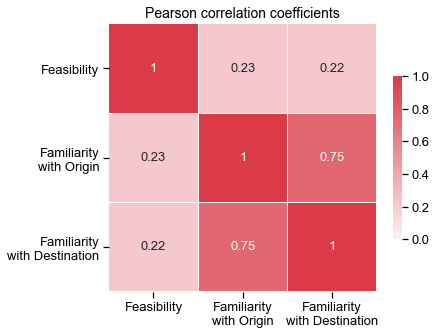

In [204]:
plotting_utils.plot_heatmap(feasibility_familiarity.to_numpy(),
                            x_labels = ['Feasibility', 'Familiarity\nwith Origin', 'Familiarity\nwith Destination'],
                            shorten_xlabel=False, figsize=(6,6), limits=(0,1))
plt.xticks(rotation=0)
plt.title('Pearson correlation coefficients')

plotting_utils.export_figure('corr_Feasibility_Familiarity_Pearson', figure_folder=figure_folder, png=True, svg=True)

In [205]:
feasibility_familiarity = batch_results[
    ['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5']].corr(method='spearman')

feasibility_familiarity

,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5
feasibility_1-5,1.000000,0.196113,0.190401
familiarity_with_origin_1-5,0.196113,1.000000,0.743249
familiarity_with_destination_1-5,0.190401,0.743249,1.000000


In [206]:
print(spearmanr(batch_results['feasibility_1-5'], batch_results['familiarity_with_origin_1-5']))
print(spearmanr(batch_results['feasibility_1-5'], batch_results['familiarity_with_destination_1-5']))
print(spearmanr(batch_results['familiarity_with_origin_1-5'], batch_results['familiarity_with_destination_1-5']))

SpearmanrResult(correlation=0.19611272998600898, pvalue=0.0)
SpearmanrResult(correlation=0.1904010488260159, pvalue=0.0)
SpearmanrResult(correlation=0.7432487433995777, pvalue=0.0)


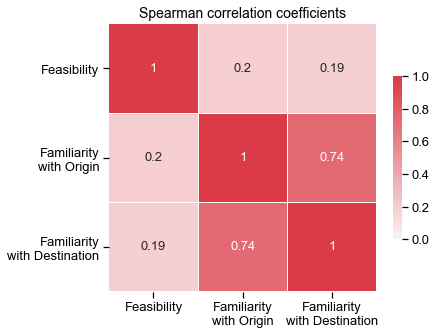

In [207]:
plotting_utils.plot_heatmap(feasibility_familiarity.to_numpy(),
                            x_labels = ['Feasibility', 'Familiarity\nwith Origin', 'Familiarity\nwith Destination'],
                            shorten_xlabel=False, figsize=(6,6), limits=(0,1))
plt.xticks(rotation=0)
plt.title('Spearman correlation coefficients')

plotting_utils.export_figure('corr_Feasibility_Familiarity_Spearman', figure_folder=figure_folder, png=True, svg=True)

The familiarity with the origin and destination occupations are correlated showing that coders generally had a similar level of familiartiy with both occupations when judging a transition. This familiarity does not seem to correlate strongly with the feasibility rating.

In [208]:
batch_results['familiarity_diff'] = (batch_results['familiarity_with_origin_1-5']
                                     - batch_results['familiarity_with_destination_1-5'])
batch_results['familiarity_total'] = (batch_results['familiarity_with_origin_1-5']
                                     + batch_results['familiarity_with_destination_1-5'])

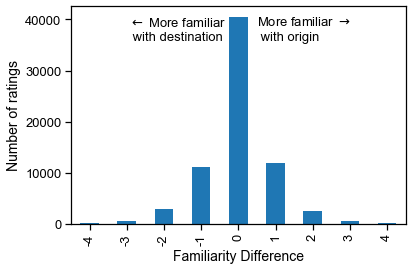

In [209]:
fig, ax = plt.subplots()

(batch_results['familiarity_diff']
 .value_counts().sort_index()
 .plot.bar(ax=ax))

ax.text(1.05, 36000, '$\leftarrow$ More familiar \n with destination')
ax.text(4.5, 36000, 'More familiar ' + r'$\rightarrow$'+ '\n with origin')
ax.set_xlabel('Familiarity Difference')
ax.set_ylabel('Number of ratings');
plotting_utils.export_figure('ratings_Familiarity_difference', figure_folder=figure_folder, png=True, svg=True)

In over 20,000 cases, coders responded by saying that they had equal familiarity with the origin and destination occupations. In less than 15,000 cases, the absolute difference in familiarity was 1. It is very uncommon to find absolute differences of 2 or more.

The distribution of differences in familiarity is highly symmetric, indicating that coders found destinations that they were more familiar with as often as they found origin occupations that they were more familiar with. 

This all raises further questions:

- Do transitions with more familiar occupations have more consistent feasibility ratings between coders?
- Does the difference in familiarity affect the feasibilty rating?

More familiar with the origin:

In [210]:
batch_results.sort_values('familiarity_diff')[['origin_label', 'destination_label', 'familiarity_diff']].tail(10)

,origin_label,destination_label,familiarity_diff
64677,midwife,respiratory therapy technician,4
19913,webmaster,knowledge engineer,4
62035,plastic rolling machine operator,mechanical forging press worker,4
67366,pharmacist,physiotherapy assistant,4
40136,construction commercial diver,director of compliance and information securit...,4
19904,webmaster,ICT intelligent systems designer,4
14122,social care worker,sales account manager,4
6090,food analyst,gauger,4
3698,travel consultant,purchaser,4
30756,bank manager,business developer,4


More familiar with the destination occupation:

In [211]:
batch_results.sort_values('familiarity_diff')[['origin_label', 'destination_label', 'familiarity_diff']].head(10)

,origin_label,destination_label,familiarity_diff
39660,lime kiln operator,speech and language therapist,-4
42629,motorcycle assembler,airport baggage handler,-4
49532,pasta operator,edge bander operator,-4
60045,straightening machine operator,electroplating machine operator,-4
40528,metal products assembler,postman/postwoman,-4
57407,mechanical forging press worker,blow moulding machine operator,-4
45481,dairy products manufacturing worker,factory hand,-4
44238,underwater construction supervisor,railway station manager,-4
193,tour operators manager,brand manager,-4
39287,oxy fuel burning machine operator,leaflet distributor,-4


In [212]:
batch_results['is_gt_2'] = batch_results['feasibility_1-5'] > 2
batch_results['is_gt_3'] = batch_results['feasibility_1-5'] > 3
batch_results['is_gt_4'] = batch_results['feasibility_1-5'] > 4

In [227]:
transition_mean = (batch_results
 .groupby(['origin_label', 'destination_label'])
 [['feasibility_1-5', 'familiarity_with_origin_1-5', 
   'familiarity_with_destination_1-5', 'familiarity_diff',
   'familiarity_total', 'is_gt_2', 'is_gt_3', 'is_gt_4' 
  ]]
 .mean())

transition_std = (batch_results
 .groupby(['origin_label', 'destination_label'])
 [['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5', 'familiarity_diff']]
 .std())

In [247]:
transition_mean.reset_index().sort_values('feasibility_1-5').head(10)

,origin_label,destination_label,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5,familiarity_diff,familiarity_total,is_gt_2,is_gt_3,is_gt_4
5103,lime kiln operator,speech and language therapist,1.0,1.750000,3.125000,-1.375000,4.875000,0.0,0.0,0.0
5069,legal guardian,recreational therapist,1.0,3.714286,3.285714,0.428571,7.000000,0.0,0.0,0.0
572,advanced physiotherapist,tax compliance officer,1.0,3.000000,2.888889,0.111111,5.888889,0.0,0.0,0.0
8897,weaving machine operator,astronomer,1.0,3.000000,4.142857,-1.142857,7.142857,0.0,0.0,0.0
2229,composer,lexicographer,1.0,3.125000,2.375000,0.750000,5.500000,0.0,0.0,0.0
8743,vehicle rental agent,geographic information systems specialist,1.0,3.375000,3.250000,0.125000,6.625000,0.0,0.0,0.0
8694,user interface developer,architect,1.0,2.666667,3.500000,-0.833333,6.166667,0.0,0.0,0.0
6402,podiatrist,aircraft marshaller,1.0,2.666667,2.333333,0.333333,5.000000,0.0,0.0,0.0
2216,community health worker,interpreter,1.0,3.125000,3.375000,-0.250000,6.500000,0.0,0.0,0.0
4194,glass polisher,mediator,1.0,2.444444,2.333333,0.111111,4.777778,0.0,0.0,0.0


In [248]:
transition_mean.reset_index().sort_values('feasibility_1-5').tail(10)

,origin_label,destination_label,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5,familiarity_diff,familiarity_total,is_gt_2,is_gt_3,is_gt_4
9017,welder,metal rolling mill operator,4.571429,3.714286,2.714286,1.000000,6.428571,1.0,1.000000,0.571429
8257,textile product developer,textile printer,4.571429,2.857143,2.857143,0.000000,5.714286,1.0,0.857143,0.714286
5738,motorcycle delivery person,postman/postwoman,4.625000,3.750000,4.125000,-0.375000,7.875000,1.0,1.000000,0.625000
2785,data entry clerk,data entry supervisor,4.625000,3.125000,3.250000,-0.125000,6.375000,1.0,0.875000,0.750000
7437,shop assistant,bartender,4.625000,4.625000,4.500000,0.125000,9.125000,1.0,1.000000,0.625000
1188,bindery operator,paperboard products assembler,4.666667,3.000000,2.666667,0.333333,5.666667,1.0,1.000000,0.666667
743,animal handler,animal care attendant,4.666667,3.500000,3.500000,0.000000,7.000000,1.0,1.000000,0.666667
4389,hotel butler,steward/stewardess,4.714286,3.714286,3.714286,0.000000,7.428571,1.0,1.000000,0.714286
4911,kitchen porter,kitchen assistant,4.714286,3.714286,4.000000,-0.285714,7.714286,1.0,0.857143,0.857143
4451,human resources officer,human resources manager,4.833333,3.500000,3.666667,-0.166667,7.166667,1.0,1.000000,0.833333


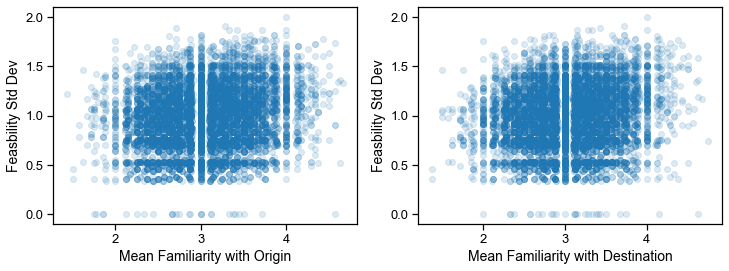

In [272]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(transition_mean['familiarity_with_origin_1-5'], transition_std['feasibility_1-5'], alpha=0.15)
axs[0].set_xlabel('Mean Familiarity with Origin')
axs[0].set_ylabel('Feasbility Std Dev')

axs[1].scatter(transition_mean['familiarity_with_destination_1-5'], transition_std['feasibility_1-5'], alpha=0.15)
axs[1].set_xlabel('Mean Familiarity with Destination')
axs[1].set_ylabel('Feasbility Std Dev');


In [273]:
print(spearmanr(transition_std['feasibility_1-5'], transition_mean['familiarity_with_origin_1-5']))
print(spearmanr(transition_std['feasibility_1-5'], transition_mean['familiarity_with_destination_1-5']))

SpearmanrResult(correlation=0.14987661207461192, pvalue=6.254276633341883e-47)
SpearmanrResult(correlation=0.11748257609852011, pvalue=2.249341975764867e-29)


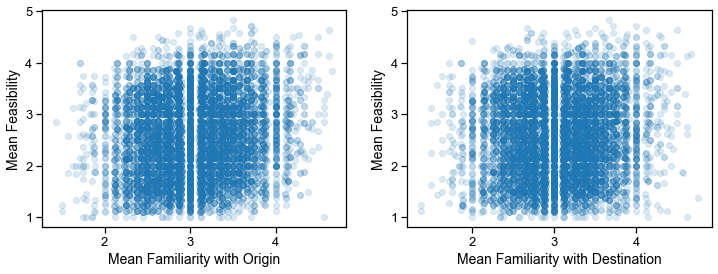

In [230]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(transition_mean['familiarity_with_origin_1-5'], transition_mean['feasibility_1-5'], alpha=0.15)
axs[0].set_xlabel('Mean Familiarity with Origin')
axs[0].set_ylabel('Mean Feasibility')

axs[1].scatter(transition_mean['familiarity_with_destination_1-5'], transition_mean['feasibility_1-5'], alpha=0.15)
axs[1].set_xlabel('Mean Familiarity with Destination')
axs[1].set_ylabel('Mean Feasibility');

plotting_utils.export_figure('Mean_Feasibility_Familiarity', figure_folder=figure_folder, png=True, svg=True)


In [269]:
print(spearmanr(transition_mean['feasibility_1-5'], transition_mean['familiarity_with_origin_1-5']))
print(spearmanr(transition_mean['feasibility_1-5'], transition_mean['familiarity_with_destination_1-5']))
print(spearmanr(transition_mean['familiarity_with_origin_1-5'], transition_mean['familiarity_with_destination_1-5']))

SpearmanrResult(correlation=0.12029385142760464, pvalue=1.0011183944287439e-30)
SpearmanrResult(correlation=0.047472022802234226, pvalue=5.795653048332515e-06)
SpearmanrResult(correlation=0.5925154155903014, pvalue=0.0)


In [215]:
# from skbio.diversity.alpha import shannon, simpson

In [216]:
# transition_shannon = []

# for col in ['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5']:
#     shan = transition_mean = (batch_results.groupby(['origin_label', 'destination_label'])[col].apply(shannon))
#     transition_shannon.append(shan)
    
# transition_shannon = pd.concat(transition_shannon, axis=1)

In [218]:
# transition_simpson = []

# for col in ['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5']:
#     shan = transition_mean = (batch_results.groupby(['origin_label', 'destination_label'])[col].apply(shannon))
#     transition_shannon.append(shan)
    
# transition_shannon = pd.concat(transition_shannon, axis=1)

In [220]:
# fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

# axs[0].scatter(transition_mean['familiarity_diff'], transition_mean['feasibility_1-5'], alpha=0.15)
# axs[0].set_xlabel('Mean Absolute Difference in Familiarity')
# axs[0].set_ylabel('Mean Feasbility')

# axs[1].scatter(transition_mean['familiarity_with_origin_1-5'], transition_std['feasibility_1-5'], alpha=0.15)
# axs[1].set_xlabel('Mean Familiarity with Origin')
# axs[1].set_ylabel('Feasbility Std Dev')

# axs[2].scatter(transition_mean['familiarity_with_destination_1-5'], transition_std['feasibility_1-5'], alpha=0.15)
# axs[2].set_xlabel('Mean Familiarity with Destination')
# axs[2].set_ylabel('Feasbility Std Dev');

The difference in familiarity between origin and destination occupations seems to have a very limited negative correlation (-0.104) with the actual feasibility score. However, both very high and very low average feasibilities are recorded at all levels of familiarity difference. 

The familiarity of either the origin or destination does not lead to a wider dispersion in the feasibility rating.

Most contentious transitions:

In [267]:
transition_std.sort_values('feasibility_1-5', ascending=False).head(20)['feasibility_1-5']

origin_label                            destination_label             
sales assistant                         locker room attendant             2.000000
maternity support worker                radiographer                      1.902379
orthoptist                              occupational therapist            1.889822
physiotherapist                         podiatrist                        1.864454
funeral services director               funeral attendant                 1.864454
hospitality establishment receptionist  post office counter clerk         1.861899
academic support officer                higher education lecturer         1.861899
credit adviser                          economic policy officer           1.816590
tutor                                   circus arts teacher               1.812654
drafter                                 printed circuit board designer    1.812654
secondary school teaching assistant     lifeguard instructor              1.812654
advanced physiot

In [242]:
# transition_std.sort_values('feasibility_1-5', ascending=False).tail(20)['feasibility_1-5']

In [222]:
results_breakdown = (batch_results
                     .groupby(['origin_label', 'destination_label', 'feasibility_1-5'])['classification_id']
                     .count()
                     .unstack()
                     .fillna(0))
results_breakdown_norm = results_breakdown.div(results_breakdown.sum(axis=1), axis=0)

In [223]:
from sklearn.metrics import pairwise_distances

In [224]:
results_breakdown_norm_ = results_breakdown_norm.sample(200, random_state=0)

dists = pd.DataFrame(
    1 - pairwise_distances(results_breakdown_norm_, metric='euclidean'),
    index=results_breakdown_norm_.index,
    columns=results_breakdown_norm_.index
)

/Users/karliskanders/opt/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



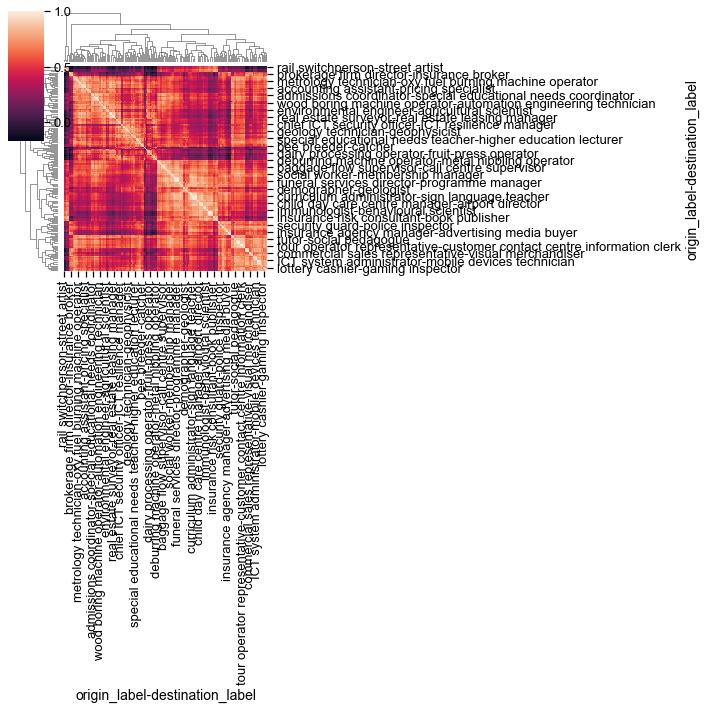

In [225]:
sns.clustermap(dists)

Clusters off the diagonal could indicate areas of disagreement.

We might want to threshold the level of uncertainty.

Do people who give different results also cite different reasons? (could see if there is a relationship between std dev of the feasibility and entropy of the reason choices)

What happens when you drop out the extremes?

In [33]:
x = (pd.get_dummies(
    batch_results['feasibility_1-5'])
 .groupby(batch_results['subject_ids'])
 .sum()
 .apply(shannon, axis=1))
y = batch_results.groupby('subject_ids')['feasibility_1-5'].mean()

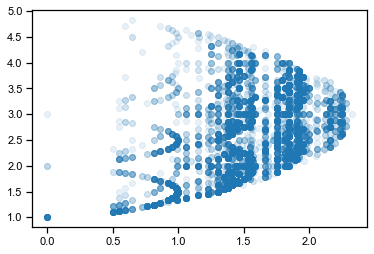

In [34]:
plt.scatter(x, y, alpha=0.1)

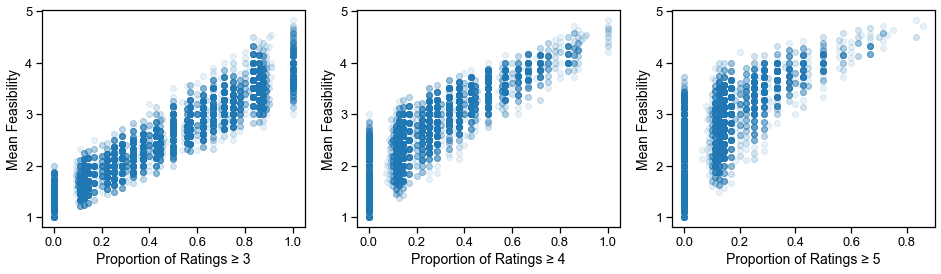

In [237]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

for i, col in enumerate(['is_gt_2', 'is_gt_3', 'is_gt_4']):
    axs[i].scatter(transition_mean[col], transition_mean['feasibility_1-5'], alpha=0.1)
    axs[i].set_xlabel(f'Proportion of Ratings ≥ {int(col.split("_")[-1]) + 1}')
    axs[i].set_ylabel('Mean Feasibility')
    
plotting_utils.export_figure('Mean_Feasibility_Proportion_ratings', figure_folder=figure_folder, png=True, svg=True)    

In [258]:
df = transition_mean.reset_index()
df = df[df['feasibility_1-5']<3]
(df.is_gt_2 > 0.2).sum() / len(df)
# (df['feasibility_1-5']<3).sum() / transition_mean.shape[0]

0.6658940397350993

In [266]:
(df.is_gt_2 > 0.4).sum() / len(df)

0.3379139072847682

In [ ]:
# (df['feasibility_1-5']<3).sum() / transition_mean.shape[0]

In [262]:
# ((transition_mean['is_gt_2'] >= 0.2) & (transition_mean['feasibility_1-5'] < 2)).sum() / transition_mean.shape[0]

In [261]:
# ((transition_mean['is_gt_3'] >= 0.4) & (transition_mean['feasibility_1-5'] < 3)).sum() / transition_mean.shape[0]

In [260]:
# ((transition_mean['is_gt_4'] >= 0.4) & (transition_mean['feasibility_1-5'] < 3)).sum() / transition_mean.shape[0]

## 1.3 Describe the contributors

In [275]:
# fig, ax = plt.subplots()
# ax.hist(batch_results.drop_duplicates('coder_id').year_of_birth, bins=20)
# ax.set_xlabel('Year of Birth')
# ax.set_ylabel('Frequency');

In [282]:
# coder_df = batch_results.groupby('coder_id').count()

In [313]:
coder_df = batch_results.drop_duplicates('coder_id').copy()
N = len(coder_df)
print(N)

387


In [314]:
gender_breakdown = coder_df.groupby('gender').agg({'coder_id': 'count'})
gender_breakdown

,coder_id
gender,
Female,151
Male,234
Prefer not to say,1
Prefer to self-describe,1


In [315]:
gender_breakdown.loc['Male', 'coder_id'] / N

0.6046511627906976

In [316]:
gender_breakdown.loc['Female', 'coder_id'] / N

0.39018087855297157

In [317]:
# Qualification distribution
coder_df.groupby('highest_qualification').agg({'coder_id': 'count'}).sort_values('coder_id')

,coder_id
highest_qualification,
Master'degree,8
Doctorate,9
Bachelor'degree,10
Higher National Certificate,20
Higher National Diploma,24
GCSE,30
A-Level,62
Master's degree,72
Bachelor's degree,152


In [318]:
coder_df.highest_qualification.unique()

array(["Master'degree", "Bachelor's degree", 'Doctorate', 'GCSE',
       'A-Level', "Master's degree", 'Higher National Diploma',
       "Bachelor'degree", 'Higher National Certificate'], dtype=object)

In [319]:
def rename_qual(x):
    rename_dict = {"Master'degree": "Master's degree", "Bachelor'degree": "Bachelor's degree"}
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    

In [320]:
coder_df['highest_qualification'] = coder_df['highest_qualification'].apply(lambda x: rename_qual(x))

In [322]:
qualifications = coder_df.groupby('highest_qualification').agg({'coder_id': 'count'}).sort_values('coder_id')
qualifications

,coder_id
highest_qualification,
Doctorate,9
Higher National Certificate,20
Higher National Diploma,24
GCSE,30
A-Level,62
Master's degree,80
Bachelor's degree,162


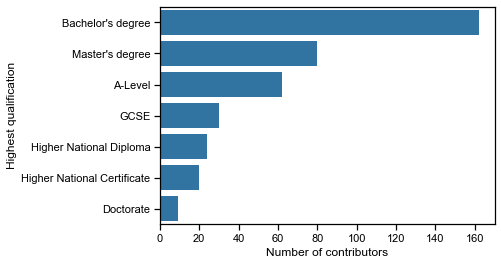

In [329]:
plt.figure(figsize=(6,4))
sns.barplot(data=qualifications.reset_index().sort_values('coder_id', ascending=False), y='highest_qualification', x='coder_id', color='C0')
plt.ylabel('Highest qualification')
plt.xlabel('Number of contributors')
plotting_utils.export_figure('contributors_qualifications', figure_folder=figure_folder, png=True, svg=True)

In [330]:
# How many 'questionable' coders?
coder_df = batch_results.drop_duplicates('coder_id')
coder_df.groupby('questionable_respondant_flag').agg({'coder_id': 'count'})

,coder_id
questionable_respondant_flag,
False,377
True,10


In [325]:
# # Coder locations
# coder_df = batch_results.drop_duplicates('coder_id')
# coder_df.groupby('nation').agg({'coder_id': 'count'})

### 1.3.1 Check the activity of each coder

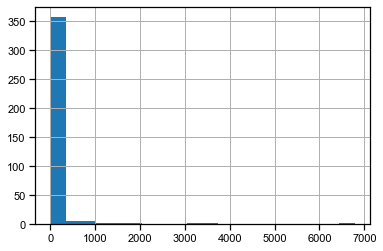

In [337]:
# Number of assessments by a coder
coder_counts = batch_results.groupby('coder_id').agg({'classification_id': 'count'})
coder_counts.classification_id.hist(bins=20)
plt.show()

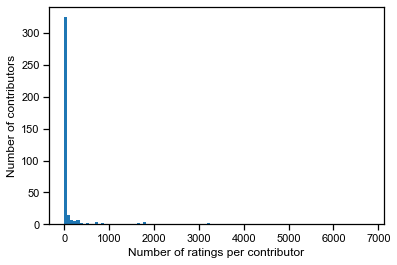

In [348]:
fig, ax = plt.subplots()
ax.hist(coder_counts['classification_id'], bins=100)
ax.set_xlabel('Number of ratings per contributor')
ax.set_ylabel('Number of contributors');
# ax.set_yscale('log')
plotting_utils.export_figure('contributors_Activity', figure_folder=figure_folder, png=True, svg=True)

In [349]:
coder_counts['classification_id'].median()

3.0

In [353]:
(coder_counts['classification_id']==1).sum()/N

0.3178294573643411

In [377]:
coder_counts

,classification_id
coder_id,
006823238a045a337fa1,1
0075f7b05ec3000fb393,2
03f0e02da4ebb031d3ba,5
04c32f8a735ac021b8d0,6
04e53412e4e90f10b318,3
...,...
fd0acd0253b6bb69dcbe,14
fd62d24e51a96cd01d32,3
fdb1b4117534a44c5f5e,65


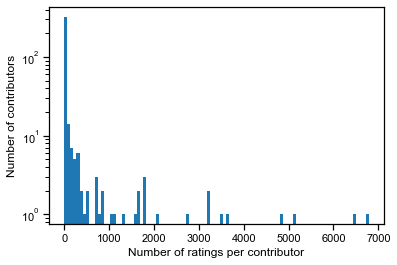

In [350]:
fig, ax = plt.subplots()
ax.hist(coder_counts['classification_id'], bins=100)
ax.set_xlabel('Number of ratings per contributor')
ax.set_ylabel('Number of contributors');
ax.set_yscale('log')
plotting_utils.export_figure('contributors_Activity_Log', figure_folder=figure_folder, png=True, svg=True)

Note the fat tail of the distribution - we should be aware of the outsized influence of 'super-users'.

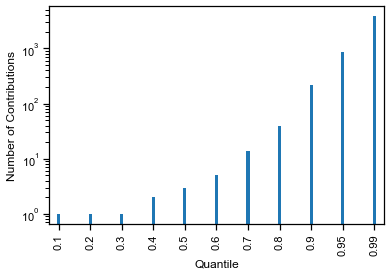

In [378]:
fig, ax = plt.subplots()
(coder_counts
 .quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
 .plot.bar(width=0.1, legend=None, ax=ax))
ax.set_yscale('log')
ax.set_xlabel('Quantile')
ax.set_ylabel('Number of Contributions');

In [354]:
# fig, ax = plt.subplots()
# (coder_counts
#  .quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
#  .plot.bar(width=0.1, legend=None, ax=ax))
# ax.set_yscale('log')
# ax.set_xlabel('Quantile')
# ax.set_ylabel('Number of Contributions');

In [381]:
np.percentile(coder_counts.classification_id, 50)

3.0

Only 30% of coders made more than 10 contributions, while 50% made 3 or less.

How many high count coders can we drop out while still maintaining integrity of the results?

In [384]:
from scipy.stats import percentileofscore

In [382]:
np.percentile(coder_counts.classification_id, 90)

216.4000000000002

In [385]:
percentileofscore(coder_counts.classification_id, 100)

85.27131782945736

In [398]:
(coder_counts.classification_id >= 100).sum()

57

In [387]:
coder_counts.classification_id.max()

6786

In [ ]:
# Note: 50% of the total number of validations are provided by about 10 people 

# Plot an empirical cumulative distribution
x = np.sort(coder_counts.classification_id.to_list())
y = np.cumsum(x) / len(batch_results)
plt.scatter(x, y, linewidths=1)
plt.ylabel('Number of total validations')
plt.xlabel('Number of validations per single coder')

plt.show()

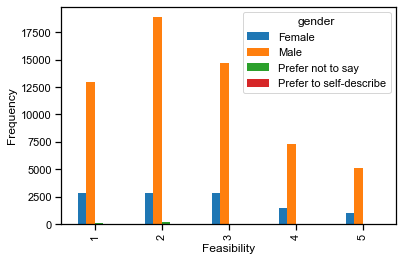

In [56]:
fig, ax = plt.subplots()

batch_results.groupby('gender')['feasibility_1-5'].value_counts().unstack(0).plot.bar(ax=ax)

ax.set_xlabel('Feasibility')
ax.set_ylabel('Frequency');

Women seem to award a higher fraction of the most pessimistic answer but also the most optimistic.

In [57]:
low_count_coder_ids = coder_counts[coder_counts['classification_id'] < 100].index.values

low_count_batch_results = batch_results.set_index('coder_id').loc[low_count_coder_ids].reset_index()

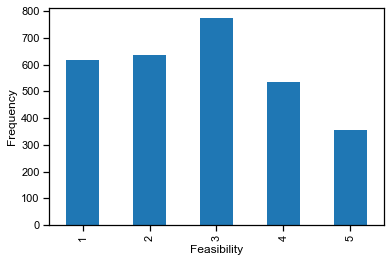

In [58]:
fig, ax = plt.subplots()

low_count_batch_results.groupby('feasibility_1-5').agg({'classification_id': 'count'}).plot.bar(ax=ax, legend=False)
ax.set_xlabel('Feasibility')
ax.set_ylabel('Frequency');

Removing the high responders.

Do contributor's average ratings change over time as they become 'sensitised' to the careers or are they self consistent across time?

## 1.4 Reasons for ratings

In [59]:
batch_results['reasons'] = batch_results['Reasons'].str.extract(r'.*?\*\*(.*)\*\*.*')
batch_results['reasons'] = batch_results['reasons'].str.lower().str.replace(' ', '_')
batch_results = batch_results.drop('Reasons', axis=1)

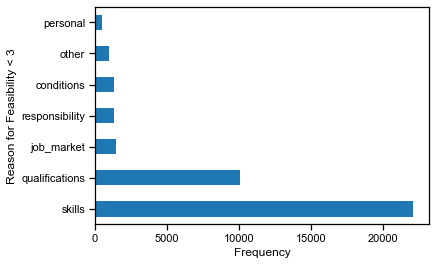

In [60]:
fig, ax = plt.subplots()
batch_results[batch_results['feasibility_1-5'] < 3]['reasons'].value_counts().plot.barh(ax=ax)
ax.set_xlabel('Frequency')
ax.set_ylabel('Reason for Feasibility < 3');

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

In [62]:
transition_reasons = (batch_results.groupby(['origin_label', 'destination_label'])['reasons']
                      .apply(lambda x: ' '.join(list(x))))

cv = CountVectorizer()
cv.fit(transition_reasons)
reason_counts = pd.DataFrame(cv.transform(transition_reasons).todense(), columns=cv.get_feature_names())
reason_share = reason_counts.divide(reason_counts.sum(axis=1), axis=0)

reason_share.index = transition_reasons.index

In [63]:
reason_share = reason_share.join(
    batch_results
    .groupby(['origin_label', 'destination_label'])
    ['feasibility_1-5'].mean()
)

In [64]:
for skill in batch_results['reasons'].value_counts().index:
    df = reason_share[reason_share['feasibility_1-5'] <= 2]
    df['inv_f'] = 5 - df['feasibility_1-5']
    df = df.sort_values([skill, 'inv_f'], ascending=False).head(10)
    print(skill.replace('_', ' ').title())
    [print('-', ' ==> '.join(_)) for _ in df.index.to_list()]
    print('')

Skills
- economic policy officer ==> fisheries master
- rigger ==> cosmetics production machine operator
- textile product developer ==> promoter
- ATM repair technician ==> stringed musical instrument maker
- hand brick moulder ==> auctioneer
- security guard ==> sauce production operator
- urban planner ==> bee breeder
- poultry sexer ==> product assembly inspector
- fisheries assistant engineer ==> movie distributor
- surface miner ==> proofreader

Qualifications
- user interface developer ==> architect
- relocation officer ==> lawyer
- food analyst ==> materials engineer
- insurance risk consultant ==> meteorologist
- orthoptist ==> pharmacist
- pipeline route manager ==> materials engineer
- orthoptist ==> specialist chiropractor
- corporate training manager ==> secondary school teacher
- optometrist ==> podiatrist
- optometrist ==> speech and language therapist

Other
- animation layout artist ==> dramaturge
- insurance agency manager ==> provincial governor
- actuarial consultan

/Users/grichardson/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 1.5 Coder Backgrounds

In [359]:
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval

In [374]:
df = batch_results.drop_duplicates('coder_id').copy()
# df = batch_results.copy()
df['background'] = df['background'].apply(literal_eval)

In [375]:
mlb = MultiLabelBinarizer()
mlb.fit(df['background'])

background_df = pd.DataFrame(mlb.transform(df['background']), index=df.index, columns=mlb.classes_)


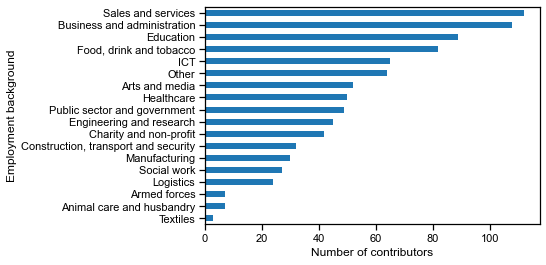

In [376]:
background_df.sum().sort_values().plot.barh()
plt.xlabel('Number of contributors')
plt.ylabel('Employment background');
plotting_utils.export_figure('contributors_Backgrounds', figure_folder=figure_folder, png=True, svg=True)

# 2. Check the coverage of transitions

See if all of the transitions provided by us have been tested by the validators

In [388]:
# Check that the # of transitions match
assert(len(batch) == len(batch_results.subject_ids.unique()))

In [389]:
# Check if any transitions are missing
df = batch.merge(batch_results[['origin_id', 'destination_id', 'subject_ids']],
                 on=['origin_id', 'destination_id'])
df[df.subject_ids.isnull()]

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills,subject_ids


In [390]:
df.sample()

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills,subject_ids
10960,770,humanitarian advisor,Humanitarian advisors ensure strategies to red...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,observe confidentiality; use communication tec...,facilitate job market access,document interviews; teach writing; online job...,52682757


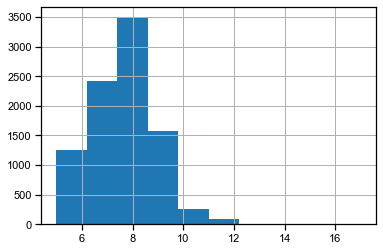

In [391]:
# Note: There are at least 5 ratings for each transition
transition_counts = batch_results.groupby('subject_ids').count()
transition_counts.classification_id.hist()
plt.show()

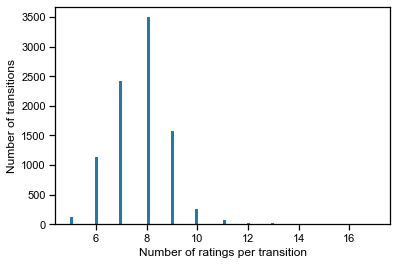

In [401]:
fig, ax = plt.subplots()
ax.hist(transition_counts['classification_id'], bins=100)
ax.set_xlabel('Number of ratings per transition')
ax.set_ylabel('Number of transitions');
# ax.set_yscale('log')
plotting_utils.export_figure('transitions_Ratings', figure_folder=figure_folder, png=True, svg=True)

In [393]:
transition_counts.classification_id.min()

5

In [392]:
transition_counts.classification_id.max()

17

In [403]:
transition_counts.classification_id.mean()

7.720728629430484

# 3. Check the correlation between feasibility and similarity measures

In [404]:
def get_similarities(df, W, col_name = 'similarity'):
    """ Find similarity values in matrix W, for transitions specified in dataframe df """
    sim_list = []
    for j, row in df.iterrows():
        sim = W[int(row.origin_id), int(row.destination_id)]
        sim_list.append(sim)
    df[col_name] = sim_list 
    return df


In [ ]:
TODO: GET SUPER-USER CODER IDs
CREATE A TABLE WITH CORRELATION COEFFICIENTS FOR EACH SIMILARITY METRIC AND # the number of superusers removed

In [405]:
# Check the mean feasibility for each transition
batch_results_agg = (batch_results
                     .groupby('subject_ids')
                     .agg({'feasibility_1-5': 'mean'})
                     .reset_index())

# Add occupation IDs 
batch_results_agg = batch_results_agg.merge(batch_results.drop_duplicates('subject_ids')[[
    'origin_id', 'destination_id',
    'origin_label', 'destination_label',
    'subject_ids']], on=['subject_ids'], how='left')

batch_results_agg.sample(5)

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label
563,52452772,2.625000,596,1983,financial manager,ICT product manager
1680,52685186,3.000000,1608,1702,user interface developer,database designer
4285,53137247,2.222222,1925,2000,ICT quality assurance manager,ICT resilience manager
1133,52683625,3.333333,1164,2131,ticket issuing clerk,guide
2417,52686883,1.600000,2357,1127,tax inspector,court bailiff


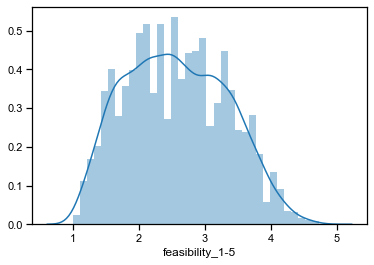

In [406]:
sns.distplot(batch_results_agg['feasibility_1-5'])
plt.show()

In [407]:
# Add similarity values to the table
df = get_similarities(batch_results_agg, sims.W_combined, col_name = 'similarity_combined')
df = get_similarities(df, sims.W_essential, col_name = 'similarity_essential_skills')
df = get_similarities(df, sims.W_all_to_essential, col_name = 'similarity_optional_skills')
df = get_similarities(df, sims.W_activities, col_name = 'similarity_activities')
df = get_similarities(df, sims.W_work_context, col_name = 'similarity_work_context')

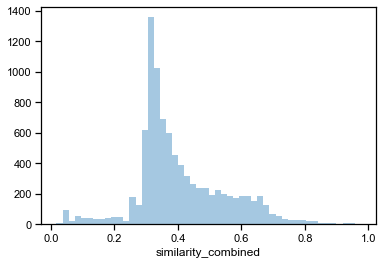

In [427]:
sns.distplot(df.similarity_combined, kde=False)

### 3.1 Combined similarity measure

Pearson correlation: (0.6964873742301811, 0.0)
Spearman correlation: SpearmanrResult(correlation=0.7063937609987885, pvalue=0.0)


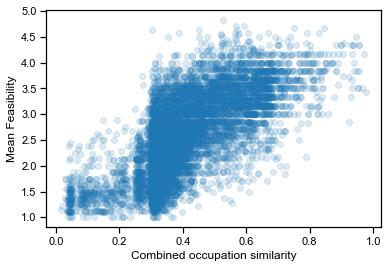

In [418]:
def plot_scatter(df=df, x='similarity', y='feasibility_1-5'):
    plt.scatter(
        x=df[x],
        y=df[y],
        alpha=0.15)
    plt.xlabel(x)
    plt.ylabel('Mean Feasibility')
    plt.xlabel(x)    
    print(f'Pearson correlation: {pearsonr(df[x], df[y])}')
    print(f'Spearman correlation: {spearmanr(df[x], df[y])}')
    
plot_scatter(x='similarity_combined', y='feasibility_1-5')
plt.xlabel('Combined occupation similarity')
plotting_utils.export_figure('corr_Feasibility_vs_Combined_similarity', figure_folder=figure_folder, png=True, svg=True)

# plt.show()

In [ ]:
# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0)))+b
#     return (y)

# p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')


In [412]:
# Check the least feasible transitions
# (definitely some odd ones there)
df.sort_values('feasibility_1-5').head(20)

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label,similarity_combined,similarity_essential_skills,similarity_optional_skills,similarity_activities,similarity_work_context
2944,53135906,1.0,29,2867,legal guardian,recreational therapist,0.370220,2.039885e-01,2.039885e-01,3.409745e-01,0.731929
4903,53137865,1.0,1611,2517,roustabout,digital games designer,0.049317,5.839378e-05,5.855384e-05,4.440892e-16,0.197150
1550,52684850,1.0,1510,868,composer,lexicographer,0.319922,4.580137e-07,4.852017e-07,5.492440e-01,0.730445
5297,53138259,1.0,733,1857,vehicle rental agent,geographic information systems specialist,0.234958,2.119138e-04,5.384992e-04,3.419322e-01,0.597150
5231,53138193,1.0,506,1843,carpenter,aircraft pilot,0.206879,2.009773e-04,1.352152e-03,2.398687e-01,0.586095
5057,53138019,1.0,557,1934,boatswain,advanced physiotherapist,0.120557,4.908830e-04,5.061102e-04,7.801290e-02,0.403220
2621,52690178,1.0,2638,2880,asset manager,natural resources consultant,0.308654,2.037628e-04,2.358368e-04,4.896805e-01,0.744496
597,52682320,1.0,600,2076,security guard,aviation inspector,0.308610,1.716675e-03,1.838664e-03,5.351250e-01,0.695761
5010,53137972,1.0,1790,141,user interface designer,animal therapist,0.099228,1.222089e-04,1.227670e-04,6.166257e-02,0.335005
4823,53137785,1.0,811,774,glass polisher,mediator,0.036712,6.249365e-06,1.888366e-05,1.332012e-02,0.133503


In [80]:
# Check the least feasible transitions
# (definitely some odd ones there)
df.sort_values('feasibility_1-5').tail(10)

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label,similarity_combined,similarity_essential_skills,similarity_optional_skills,similarity_activities,similarity_work_context
3557,53136519,4.571429,1002,2150,industrial engineer,process engineer,0.605071,0.520020,0.837764,0.195981,0.866520
8685,53142275,4.571429,1128,1642,toymaker,doll maker,0.669089,0.537911,0.770823,0.367623,1.000000
1175,52683772,4.625000,1196,2065,data entry clerk,data entry supervisor,0.450667,0.249218,0.568865,0.296492,0.688094
146,52451592,4.625000,139,573,shop assistant,bartender,0.302900,0.104503,0.196803,0.266477,0.643816
7886,53141476,4.625000,2151,1518,motorcycle delivery person,postman/postwoman,0.570813,0.624065,0.691089,0.414659,0.553440
8954,53142544,4.666667,867,2902,bindery operator,paperboard products assembler,0.750683,0.609534,0.998499,0.667971,0.726730
9071,53142661,4.666667,374,138,animal handler,animal care attendant,0.846336,0.842657,0.917541,0.918486,0.706660
7849,53141439,4.714286,2674,1062,hotel butler,steward/stewardess,0.566671,0.665701,0.665705,0.365661,0.569617
8053,53141643,4.714286,2842,2634,kitchen porter,kitchen assistant,0.591632,0.527297,0.631051,0.522001,0.686179
2460,52689775,4.833333,2490,2827,human resources officer,human resources manager,0.525282,0.270378,0.652685,0.356846,0.821218


### 3.2 Essential skills similarity measure

Pearson correlation: (0.6764875698562529, 0.0)
Spearman correlation: SpearmanrResult(correlation=0.6992837855685615, pvalue=0.0)


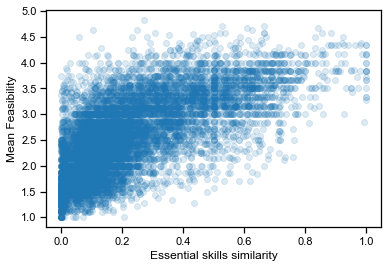

In [425]:
x='similarity_essential_skills'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Essential skills similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### 3.3 Optional skills similarity measure

Note: Optional skills similarity measures the similarity between all ('essential' and 'optional') skills at the origin occupation, and the 'essential' skills at the destination occupation.

Pearson correlation: (0.7578059352967147, 0.0)
Spearman correlation: SpearmanrResult(correlation=0.7734076215956829, pvalue=0.0)


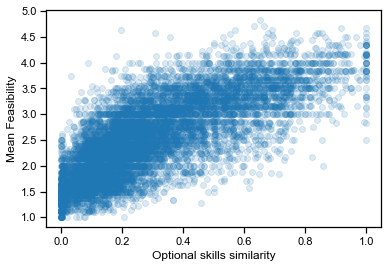

In [424]:
x='similarity_optional_skills'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Optional skills similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### 3.4 Work activity similarity measure

Pearson correlation: (0.3304338086140815, 4.533049060830223e-231)
Spearman correlation: SpearmanrResult(correlation=0.3029453013080132, pvalue=9.743575640118783e-193)


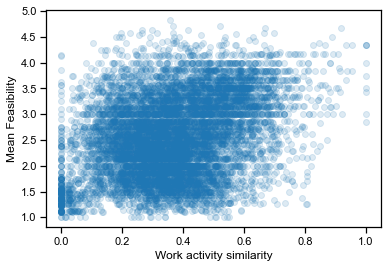

In [422]:
x='similarity_activities'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Work activity similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### 3.5 Work context similarity measure

Pearson correlation: (0.24324393753240436, 7.420690962834337e-123)
Spearman correlation: SpearmanrResult(correlation=0.14423999270165022, pvalue=1.4624209910547692e-43)


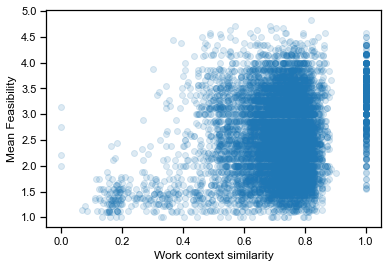

In [423]:
x='similarity_work_context'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Work context similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### 3.6 Similarity Scores and Disagreement

In [97]:
df = df.set_index('subject_ids')
df = df.merge(batch_results.groupby('subject_ids')['feasibility_1-5'].std(),
              left_index=True, right_index=True)


In [98]:
df = df.rename(columns={'feasibility_1-5_x': 'feasibility_mean', 'feasibility_1-5_y': 'feasibility_std'})

## Robustness test w.r.t super-users

In [439]:
# Number of coders providing close to half of the results
np.where(np.flip(y)>=0.5)[0][-1]

7

In [442]:
# Number of coders providing close to 80% of the results of the results
np.where(np.flip(y)>=0.2)[0][-1]

19

In [443]:
sorted_coders = coder_counts.sort_values('classification_id', ascending=False)

In [461]:
sorted_coders.head(8).sum() / len(batch_results)

classification_id    0.523472
dtype: float64

In [465]:
sorted_coders.head(8)

,classification_id
coder_id,
a33630934d5122edc8cb,6786
b929c3beb0e7ffb1ea4a,6451
30b1fb752d7b16f8968d,5156
566802cf6d9c32c4b9d6,4826
f989db16c0d3fca1f960,3660
32f99cea1d9ea469bdfe,3516
9fa97ce4c309a3033415,3239
6d45a1651ba5423e7762,3197


In [466]:
# Remove super-coders list
super_coders = sorted_coders.head(8).index.to_list()
super_coders

['a33630934d5122edc8cb',
 'b929c3beb0e7ffb1ea4a',
 '30b1fb752d7b16f8968d',
 '566802cf6d9c32c4b9d6',
 'f989db16c0d3fca1f960',
 '32f99cea1d9ea469bdfe',
 '9fa97ce4c309a3033415',
 '6d45a1651ba5423e7762']

In [474]:
df.head()

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label,similarity_combined,similarity_essential_skills,similarity_optional_skills,similarity_activities,similarity_work_context
0,52451278,2.000000,29,2654,legal guardian,employment and vocational integration consultant,0.333975,0.117440,0.119270,0.374365,0.724825
1,52451279,2.888889,29,1803,legal guardian,special educational needs teacher,0.319810,0.019986,0.245352,0.305689,0.708213
2,52451280,2.875000,29,1036,legal guardian,social counsellor,0.364106,0.073114,0.073994,0.513570,0.795748
3,52451281,3.857143,29,2877,legal guardian,social pedagogue,0.352374,0.086090,0.165216,0.374458,0.783730
4,52451282,2.222222,29,2292,legal guardian,social services manager,0.316622,0.068399,0.069652,0.417696,0.710741


In [475]:
pearsonr(df['feasibility_1-5'], df['similarity_combined'])[0]

(0.6964873742301811, 0.0)

In [522]:
# Check the mean feasibility for each transition
similarity_columns = ['similarity_combined', 'similarity_essential_skills', 'similarity_optional_skills',
                          'similarity_activities', 'similarity_work_context']
    
def get_robustness_results(n):
    batch_results_removed = batch_results[-batch_results.coder_id.isin(super_coders[0:n])]

    batch_results_agg = (batch_results_removed
                         .groupby('subject_ids')
                         .agg({'feasibility_1-5': 'mean'})
                         .reset_index())
    
    # Add occupation IDs 
    batch_results_agg = batch_results_agg.merge(batch_results_removed.drop_duplicates('subject_ids')[[
        'origin_id', 'destination_id',
        'origin_label', 'destination_label',
        'subject_ids']], on=['subject_ids'], how='left')

    # Add similarity values to the table
    df = get_similarities(batch_results_agg, sims.W_combined, col_name = 'similarity_combined')
    df = get_similarities(df, sims.W_essential, col_name = 'similarity_essential_skills')
    df = get_similarities(df, sims.W_all_to_essential, col_name = 'similarity_optional_skills')
    df = get_similarities(df, sims.W_activities, col_name = 'similarity_activities')
    df = get_similarities(df, sims.W_work_context, col_name = 'similarity_work_context')

    corr_coeffs = {}
    for x in similarity_columns: 
        corr_coeff, pvalue = spearmanr(df[x], df['feasibility_1-5'])
        corr_coeffs[x] = corr_coeff
        corr_coeffs[x+'_p'] = pvalue
    
    corr_coeffs['n_ratings'] = len(batch_results_removed)
    corr_coeffs['n_transitions'] = len(batch_results_agg)
    corr_coeffs['mean_feasibility'] = batch_results_agg['feasibility_1-5'].mean()
    corr_coeffs['std_feasibility'] = batch_results_agg['feasibility_1-5'].std()
    
    return corr_coeffs


In [527]:
# batch_results_removed = batch_results[batch_results.coder_id.isin(super_coders[0:1])]

# batch_results_agg = (batch_results_removed
#                      .groupby('subject_ids')
#                      .agg({'feasibility_1-5': 'mean'})
#                      .reset_index())

# # Add occupation IDs 
# batch_results_agg = batch_results_agg.merge(batch_results_removed.drop_duplicates('subject_ids')[[
#     'origin_id', 'destination_id',
#     'origin_label', 'destination_label',
#     'subject_ids']], on=['subject_ids'], how='left')

# # Add similarity values to the table
# df = get_similarities(batch_results_agg, sims.W_combined, col_name = 'similarity_combined')
# df = get_similarities(df, sims.W_essential, col_name = 'similarity_essential_skills')
# df = get_similarities(df, sims.W_all_to_essential, col_name = 'similarity_optional_skills')
# df = get_similarities(df, sims.W_activities, col_name = 'similarity_activities')
# df = get_similarities(df, sims.W_work_context, col_name = 'similarity_work_context')

# corr_coeffs = {}
# for x in similarity_columns: 
#     corr_coeff, pvalue = spearmanr(df[x], df['feasibility_1-5'])
#     corr_coeffs[x] = corr_coeff
#     corr_coeffs[x+'_p'] = pvalue

# corr_coeffs['n_ratings'] = len(batch_results_removed)
# corr_coeffs['n_transitions'] = len(batch_results_agg)
# corr_coeffs['mean_feasibility'] = batch_results_agg['feasibility_1-5'].mean()
# corr_coeffs['std_feasibility'] = batch_results_agg['feasibility_1-5'].std()

# corr_coeffs

{'similarity_combined': 0.8100351603563269,
 'similarity_combined_p': 0.0,
 'similarity_essential_skills': 0.7935126947207901,
 'similarity_essential_skills_p': 0.0,
 'similarity_optional_skills': 0.8572276352073326,
 'similarity_optional_skills_p': 0.0,
 'similarity_activities': 0.4529131773413981,
 'similarity_activities_p': 0.0,
 'similarity_work_context': 0.15203997338912464,
 'similarity_work_context_p': 2.2324017534333136e-36,
 'n_ratings': 6786,
 'n_transitions': 6786,
 'mean_feasibility': 3.1373415856174476,
 'std_feasibility': 1.5663181787311011}

In [523]:
all_results=[]
for n in range(0,9):
    all_results.append(get_robustness_results(n))

In [524]:
df = pd.DataFrame(data=all_results)

In [525]:
df

,similarity_combined,similarity_combined_p,similarity_essential_skills,similarity_essential_skills_p,similarity_optional_skills,similarity_optional_skills_p,similarity_activities,similarity_activities_p,similarity_work_context,similarity_work_context_p,n_ratings,n_transitions,mean_feasibility,std_feasibility
0,0.706394,0.0,0.699284,0.0,0.773408,0.0,0.302945,9.743576e-193,0.144240,1.462421e-43,70359,9113,2.563915,0.764586
1,0.616253,0.0,0.612294,0.0,0.685819,0.0,0.239098,1.198363e-118,0.139151,1.237364e-40,63573,9113,2.501527,0.720004
2,0.600826,0.0,0.597812,0.0,0.666234,0.0,0.233091,1.079157e-112,0.135197,1.958198e-38,57122,9113,2.574237,0.720653
3,0.584616,0.0,0.580632,0.0,0.654021,0.0,0.216594,3.342226e-97,0.138085,4.917214e-40,51966,9113,2.549427,0.684386
4,0.578781,0.0,0.573447,0.0,0.649104,0.0,0.214561,2.219961e-95,0.141939,3.177008e-42,47140,9113,2.541634,0.725585
5,0.566240,0.0,0.560017,0.0,0.631782,0.0,0.207228,5.831126e-89,0.142192,2.269428e-42,43480,9113,2.582358,0.725672
6,0.566923,0.0,0.557292,0.0,0.628265,0.0,0.212159,2.992702e-93,0.142246,2.113322e-42,39964,9113,2.599543,0.726070
7,0.512257,0.0,0.503357,0.0,0.569855,0.0,0.179314,1.036409e-66,0.134826,3.154287e-38,36725,9112,2.601024,0.729064
8,0.483465,0.0,0.475597,0.0,0.536331,0.0,0.164151,7.254914e-56,0.121942,1.999601e-31,33528,9080,2.594020,0.745740


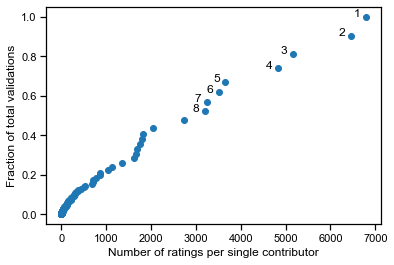

In [555]:
# Note: 50% of the total number of validations are provided by about 10 people 

# Plot an empirical cumulative distribution
x = np.sort(coder_counts.classification_id.to_list())
y = np.cumsum(x) / len(batch_results)
plt.scatter(x, y, linewidths=1)

for j in range(0,8):
    plt.text(np.flip(x)[j]-270, np.flip(y)[j]+0.0, str(j+1))

plt.ylabel('Fraction of total validations')
plt.xlabel('Number of ratings per single contributor')
plotting_utils.export_figure(f'cumulative_ratings', figure_folder=figure_folder, png=True, svg=True)

plt.show()

In [535]:
str(j)

'8'

In [ ]:
# Correlation coefficients, p-values (x 5), super users removed, number of ratings, number of transitions covered

## 4. Model

Model to predict transition feasibility:

- Create a binary vector of skill pairs to represent each job and train a regression model to predict feasibility
- Create a model of averaged origin and destination skill embeddings and train a regression model to predict feasibility
- Combination of similarity measures that we already have

New features

- Specialisation of skills (overall and adjusted overlap)

### 4.1 Simple Model - Linear Regression on Similarity Scores

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from yellowbrick.regressor import ResidualsPlot

In [101]:
train_cols = ['similarity_essential_skills', 'similarity_optional_skills', 'similarity_activities', 'similarity_work_context']
test_col = 'feasibility_mean'

X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[test_col], random_state=0, test_size=0.2, train_size=0.8)

In [102]:
polynomial_features = PolynomialFeatures(degree=2)
regression = LinearRegression()
pipeline = Pipeline([
    ("polynomial_features", polynomial_features),
     ("regression", regression)])

In [103]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# The coefficients
print('Coefficients: \n', pipeline['regression'].coef_, '\n')
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.         -0.52733524  4.92554933  0.28301375 -0.41067824 -2.8249002
  3.75605775 -0.19778286  0.87155751 -2.81238333 -0.64926257 -1.0754308
 -0.21252872  0.1963655   0.56507237] 

Mean squared error: 0.23
Coefficient of determination: 0.61


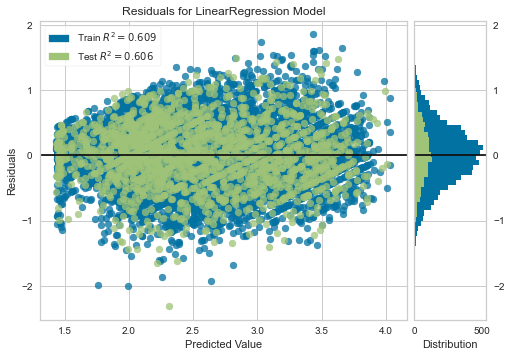

In [104]:
visualizer = ResidualsPlot(pipeline)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

In [105]:
from sklearn.svm import SVR

In [106]:
svr = SVR(kernel='rbf', C=.1, gamma='auto', epsilon=0.5)

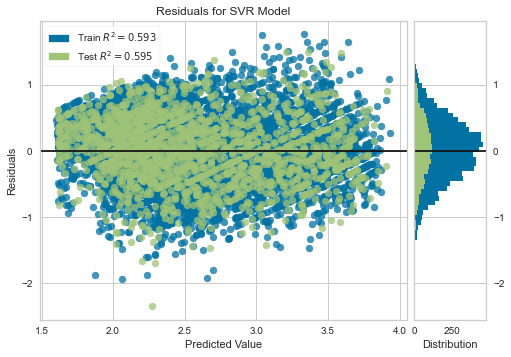

In [107]:
visualizer = ResidualsPlot(svr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

In [123]:
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.24
Coefficient of determination: 0.59


# Other Thoughts

Do we need another measure of skills similarity - where skills are structurally or semantically similar in the web of skills?